# Computer Vision Fairness Assessment
In this lesson we'll go over what is fairness/bias in machine learning, where do these issues come from, and how can we assess a model for fairness and bias. The first two points are covered in this presentation. An approach to assess fairness is presented in this notebook, where we'll loosely follow what [Gender Shades: Intersectional Accuracy Disparities in Commercial Gender Classification](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf)


## Gender Shades Paper Summary
In [Gender Shades: Intersectional Accuracy Disparities in Commercial Gender Classification](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf), Buolamwini and Gebru assess disparities in performance of commercial gender classification models across men/women and light/dark skinned individuals. The authors find that performance is significantly worse for women, darker skinned individuals, and especially poor for dark skinned women. This is in contrast to the high performance of these models when measured across the entire dataset. Part of this is due to the imbalanced nature of most computer vision datasets which will have an overrepresentation of men and light skinned individuals.

While we are recreating Buolamwini and Gebru's work, there are a few key differences.
1. The authors used the Fitzpatrick skin type classification system to determine dark or light skinned individuals because of the variation in skin type within racial/ethnic groups. In this work we're using a coarse Black vs white classification system until I can get access to the [Data Shades dataset](http://gendershades.org/)
2. We're using a gender classification system that I trained so that we can also see how to load in and assess [scikit-learn](https://scikit-learn.org/stable/) models, which I assume is more broadly applicable to our work.
3. Finally, we're using a different dataset to evaluate on than the original authors had used.

## Libraries Needed

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
from skimage.feature import hog
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter

## Load in data

### How to load an image

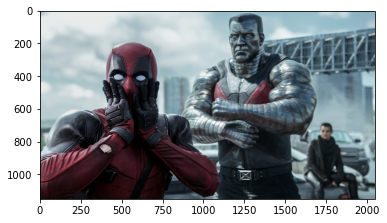

In [2]:
deadpool = Image.open("deadpool.jpg")
deadpool_matrix = np.array(deadpool)
plt.imshow(deadpool_matrix)

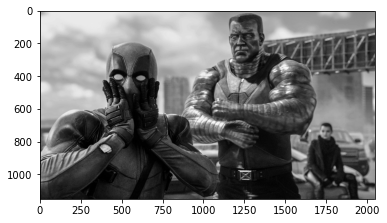

In [3]:
r,g,b = deadpool.split()
plt.imshow(np.array(r), cmap="gray")

In [4]:
def resize_image(im):
    """
    Description: Resizes an image to a square and performs some padding.
    Input:
    Output:
    TODO:
        1)
    """
    # code snagged from https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
    desired_size = 200

    old_size = im.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image

    # thumbnail is a in-place operation

    # im.thumbnail(new_size, Image.ANTIALIAS)

    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    return(new_im)
def load_image_data(path_to_data):
    """
    Description: Loads images of men and women from path which contains two folders, man and woman. The data
        is loaded and a label is provided depending on where the data came from.
    Input:
        path_to_data (str): path to folder containing a man and woman folder with images.
    Output:
        X (4D array): Each row contains an image array (h, w, ch)
        Y (1D array): Label for each image.
    TODO:
        1)
    """
    X_list = []
    Y_list = []
    inner_folder_list = ["woman/", "man/"]
    for idx, inner_folder in enumerate(inner_folder_list):
        all_image_paths = glob.glob(os.path.join(path_to_data, inner_folder) + "*.jpg")
        for image_path in tqdm(all_image_paths):
            image = Image.open(image_path)
            image = resize_image(im=image)
            data = np.asarray(image)
            X_list.append(data)
            Y_list.append(idx)
    X = np.array(X_list)
    Y = np.array(Y_list)
    return(X, Y)

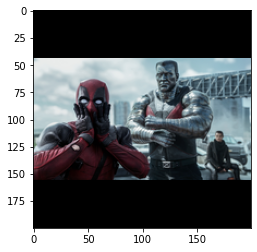

In [5]:
small_pool = resize_image(deadpool)
small_pool_matrix = np.array(small_pool)
plt.imshow(small_pool_matrix)

In [6]:
path_to_data_list = ["data/train/", "data/valid/", "data/test/"]
data_dict = {}
for path_to_data in path_to_data_list:
    X, Y = load_image_data(path_to_data)
    data_name = path_to_data.split("/")[-2]
    data_dict[data_name] = [X,Y]

100%|██████████| 170/170 [00:01<00:00, 142.75it/s]


In [7]:
for data, data_list in data_dict.items():
    print(data)
    print("\t{},{}".format(data_list[0].shape, data_list[1].shape))

train
	(1600, 200, 200, 3),(1600,)
valid
	(340, 200, 200, 3),(340,)
test
	(340, 200, 200, 3),(340,)


In [8]:
data_dict["train"][0][0,:,:,:].shape

(200, 200, 3)

## Transform the data
Unless we were to work with a model that can take in tensors (saaaayyyyy a neural network) we have to transform our three dimensional images (height, width, channel) into 1-dimensional feature vectors. These features could be as simple as descriptors for the average pixel intensity, the maximum pixel intensity, edge locations, and different combinations of segmentation. We could also flatten an image into a very, very long array. This isn't ideal though and can run into issues, namely the curse of dimensionality.

For this example I'm going to use a histogram of oriented gradients, akak HOG. I'm also going to do a lot of hand-waving here because we could use any features really and experimentation is important, but not the focus of this lesson. In short, HOG transforms an image into a one-dimensional feature vector of an image. HOG is similar to edge features in that it can identify where edges are, but it also captures the gradient and orientation. This is done in a localized manner in that the image is segmented. Finally, within each of these segments a histogram of gradient and orientation pixel values is calculated, which become the features.

In [9]:
def hog_transform(data_matrix):
    """"""
    hog_feats, hog_img = hog(
        data_matrix, pixels_per_cell=(14,14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        visualize=True, 
        block_norm='L2-Hys',
        multichannel = True)
    return(hog_feats, hog_img)

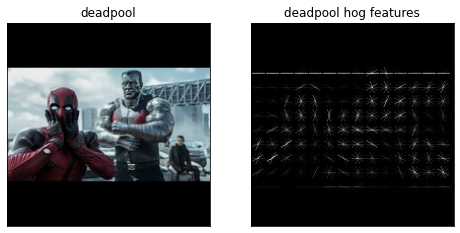

In [10]:
# Snagged from https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
deadpool_hog_feats, deadpool_hog_img = hog_transform(small_pool_matrix)
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(small_pool_matrix, cmap='gray')
ax[0].set_title('deadpool')
ax[1].imshow(deadpool_hog_img, cmap='gray')
ax[1].set_title('deadpool hog features')
plt.show()

In [11]:
print(deadpool_hog_feats.shape)

(6084,)


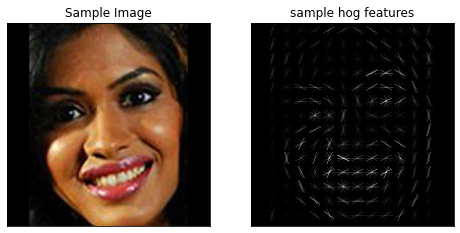

In [12]:
sample_img_matrix = data_dict["train"][0][0,:,:,:]
# Snagged from https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
sample_hog_feats, sample_hog_img = hog_transform(sample_img_matrix)
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(sample_img_matrix, cmap='gray')
ax[0].set_title('Sample Image')
ax[1].imshow(sample_hog_img, cmap='gray')
ax[1].set_title('sample hog features')
plt.show()

In [13]:
feature_dict = {}# this will be similar to the data dictionary, but transformed features.
for data_name, raw_data_list in data_dict.items():
    feature_list = []
    X = raw_data_list[0]
    for img_idx in tqdm(range(X.shape[0]), desc = data_name):
        x_curr = X[img_idx, :, :]
        x_feats, _ = hog_transform(x_curr)
        feature_list.append(x_feats)
    feature_dict[data_name] = feature_list

test: 100%|██████████| 340/340 [00:16<00:00, 20.16it/s]


## Train model

In [14]:
sgd_clf = SGDClassifier(random_state=23, max_iter=1000, tol=1e-3)
sgd_clf.fit(feature_dict["train"], data_dict["train"][1])

SGDClassifier(random_state=23)

## Evaluate Model Performance

In [15]:
preds = sgd_clf.predict(feature_dict["train"])
precision_recall_fscore_support(y_true=data_dict["train"][1], y_pred=preds, average="binary")

(0.9142857142857143, 1.0, 0.955223880597015, None)

In [16]:
def assess_performance(clf, X, Y, pos_label = 1):
    preds = sgd_clf.predict(X)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true=Y, y_pred=preds, average="binary", pos_label=pos_label)
    return(prec, rec, f1, preds)

In [17]:
prec, rec, f1, _ = assess_performance(clf = sgd_clf, X = feature_dict["train"], Y = data_dict["train"][1])
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))

precision:0.9142857142857143
recall:1.0
f1:0.955223880597015


In [18]:
prec, rec, f1, _ = assess_performance(clf = sgd_clf, X = feature_dict["valid"], Y = data_dict["valid"][1])
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))

precision:0.7387387387387387
recall:0.9647058823529412
f1:0.836734693877551


# Assessing Fairness
Hey, that's not bad. This model performs this task very well on the training data, and dips a bit on the validation data, but that's to be expected. I bet we could tinker and get the performance boosted as well, but given that we're using a single transformation and the standard model hyper-parameters I'd say we've earned ourselves a nice glass of soda, pop, or sodapop. Whatever your preference.

But before we pat ourselves on the back let's go through and look for some performance discrepancies to measure fairness.

This data comes from the [UTK: large scale face dataset](https://susanqq.github.io/UTKFace/)

In [19]:
all_new_face_data_paths = glob.glob("UTK_faces_data/*.jpg")
data_paths_to_use = []
data_path_labels = {}
for data_path in all_new_face_data_paths:
    if len(np.array(data_path.split("/")[-1].split("_"))) == 4:# some of these are no formed well
        age, gender, race = np.array(data_path.split("/")[-1].split("_"))[[0,1,2]]
        age = int(age)
        gender = int(gender)# 0=male, 1=female
        race = int(race) # 0=white, 1=Black
        if (age <= 80 )and (age >= 20 )and (race in [0, 1]):
            data_paths_to_use.append(data_path)
            if gender == 0:# flip the gender label. UTK has men as 0, while we use 1
                gender = 1
            else:
                gender = 0
            data_path_labels[data_path] = {"age":age, "gender":gender, "race":race}

gender_occurrences = []
race_occurrences = []
for label in ["gender", "race"]:
    for example, label_dict in data_path_labels.items():
        gender_occurrences.append(label_dict["gender"])
        race_occurrences.append(label_dict["race"])
for label, label_occurrences in zip(["gender", "race"], [gender_occurrences, race_occurrences]):        
    print("{} counts".format(label))
    print("\t{}".format(Counter(label_occurrences)))



all_features = []
gender_labels = []
race_labels = []
for image_path in tqdm(data_paths_to_use):
    image = Image.open(image_path)
    image = resize_image(im=image)
    data = np.asarray(image)
    features, _ = hog_transform(data)
    all_features.append(features)
    label_dict = data_path_labels[image_path]
    gender_labels.append(label_dict["gender"])
    race_labels.append(label_dict["race"])
X_utk = np.array(all_features)
Y_utk = np.array(gender_labels)
race_utk = np.array(race_labels)

  0%|          | 2/3354 [00:00<03:19, 16.76it/s]

gender counts
	Counter({0: 3488, 1: 3220})
race counts
	Counter({0: 6244, 1: 464})


100%|██████████| 3354/3354 [02:41<00:00, 20.76it/s]


1989it [00:00, 1496138.93it/s]


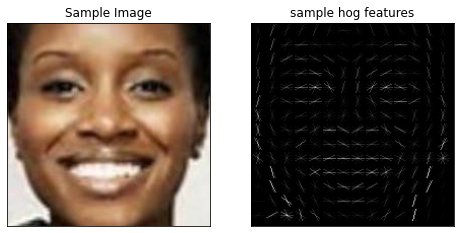

In [20]:
my_counter = 0
for idx, image_path in tqdm(enumerate(data_paths_to_use)):
    label_dict = data_path_labels[image_path]
    if label_dict['race'] == 1 and label_dict['gender'] == 0:
        if my_counter == 69:
            break
        my_counter += 1
image = Image.open(image_path)
image = resize_image(im=image)
data = np.asarray(image)
sample_hog_feats, sample_hog_img = hog_transform(data)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(data, cmap='gray')
ax[0].set_title('Sample Image')
ax[1].imshow(sample_hog_img, cmap='gray')
ax[1].set_title('sample hog features')
plt.show()

### Overall

In [21]:
prec, rec, f1, preds = assess_performance(clf = sgd_clf, X = X_utk, Y = Y_utk)
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))

precision:0.7387843704775687
recall:0.6341614906832298
f1:0.6824866310160428


### Women

In [22]:
mask_women = Y_utk == 0
prec, rec, f1, preds = assess_performance(clf = sgd_clf, X = X_utk[mask_women,:], Y = Y_utk[mask_women], pos_label = 0)
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))

precision:1.0
recall:0.7930045871559633
f1:0.8845538855132716


### Men

In [23]:
mask_men = Y_utk == 1
prec, rec, f1, _ = assess_performance(clf = sgd_clf, X = X_utk[mask_men,:], Y = Y_utk[mask_men])
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))

precision:1.0
recall:0.6341614906832298
f1:0.7761307487647282


### Black

In [24]:
mask_Black = race_utk == 1
prec, rec, f1, _ = assess_performance(clf = sgd_clf, X = X_utk[mask_Black,:], Y = Y_utk[mask_Black])
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))

precision:0.7956989247311828
recall:0.5873015873015873
f1:0.6757990867579909


### White

In [25]:
mask_white = race_utk == 0
prec, rec, f1, preds = assess_performance(clf = sgd_clf, X = X_utk[mask_white,:], Y = Y_utk[mask_white])
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))

precision:0.734678044996121
recall:0.6381401617250674
f1:0.6830147854309413


### Black Women

In [26]:
mask_Black_women = np.logical_and(mask_women, mask_Black)
# mask_Black_women = np.where(mask_Black_women)[0]
# mask_Black_women = np.random.choice(mask_Black_women, size = 75)
prec, rec, f1, preds = assess_performance(clf = sgd_clf, X = X_utk[mask_Black_women,:], Y = Y_utk[mask_Black_women], pos_label=0)
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))
print("There are {} Black women in this dataset".format(sum(mask_Black_women)))

precision:1.0
recall:0.8207547169811321
f1:0.9015544041450777
There are 106 Black women in this dataset


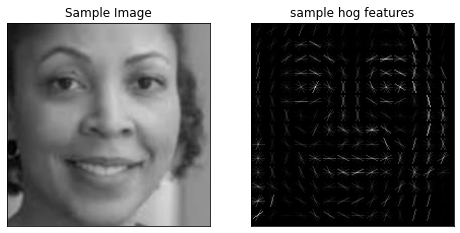

In [27]:
my_path = np.array(data_paths_to_use)[mask_Black_women][23]
image = Image.open(my_path)
image = resize_image(im=image)
data = np.asarray(image)
sample_hog_feats, sample_hog_img = hog_transform(data)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(data, cmap='gray')
ax[0].set_title('Sample Image')
ax[1].imshow(sample_hog_img, cmap='gray')
ax[1].set_title('sample hog features')
plt.show()

### White Women

In [28]:
mask_white_women = np.logical_and(mask_women, mask_white)
prec, rec, f1, preds = assess_performance(clf = sgd_clf, X = X_utk[mask_white_women,:], Y = Y_utk[mask_white_women], pos_label=0)
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))
print("There are {} white women in this dataset".format(sum(mask_white_women)))

precision:1.0
recall:0.7912087912087912
f1:0.8834355828220859
There are 1638 white women in this dataset


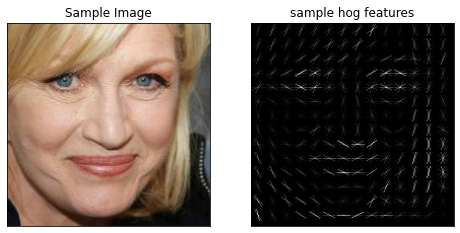

In [29]:
my_path = np.array(data_paths_to_use)[mask_white_women][78]
image = Image.open(my_path)
image = resize_image(im=image)
data = np.asarray(image)
sample_hog_feats, sample_hog_img = hog_transform(data)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(data, cmap='gray')
ax[0].set_title('Sample Image')
ax[1].imshow(sample_hog_img, cmap='gray')
ax[1].set_title('sample hog features')
plt.show()

### Black Men

In [30]:
mask_Black_men = np.logical_and(mask_men, mask_Black)
prec, rec, f1, preds = assess_performance(clf = sgd_clf, X = X_utk[mask_Black_men,:], Y = Y_utk[mask_Black_men])
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))
print("There are {} Black men in this dataset".format(sum(mask_Black_men)))

precision:1.0
recall:0.5873015873015873
f1:0.74
There are 126 Black men in this dataset


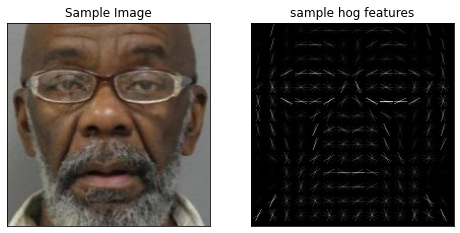

In [31]:
my_path = np.array(data_paths_to_use)[mask_Black_men][78]
image = Image.open(my_path)
image = resize_image(im=image)
data = np.asarray(image)
sample_hog_feats, sample_hog_img = hog_transform(data)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(data, cmap='gray')
ax[0].set_title('Sample Image')
ax[1].imshow(sample_hog_img, cmap='gray')
ax[1].set_title('sample hog features')
plt.show()

### White Men

In [32]:
mask_white_men = np.logical_and(mask_men, mask_white)
prec, rec, f1, preds = assess_performance(clf = sgd_clf, X = X_utk[mask_white_men,:], Y = Y_utk[mask_white_men])
print("precision:{}\nrecall:{}\nf1:{}".format(prec, rec, f1))
print("There are {} white men in this dataset".format(sum(mask_white_men)))

precision:1.0
recall:0.6381401617250674
f1:0.7791032496914849
There are 1484 white men in this dataset


## Moving Forward
These results were only half of what we were expecting. I had expected the trends found in the paper by Buolamwini and Gebru to continue here. We showed those trends again with Black men and White men, but the results were flipped for Black women and white women. Finding bias in model prediction like this is only the first step. The second is to confirm that you're looking at what you think you're looking at, and then find sources of this bias that you can remedy.

1. There's always a chance I did something wrong. Accidentally flipped the gender label or something
2. Is our data what we think it is? I plucked some of this data from kaggle and other websites. Are their calssificatio correct? How do they define their categories? Remember, Buolamwini and Gebru used skin type rather than race which can have a lot of variation in skin type.
3. We didn't really explore the data like we should have. It would be good to go into our training data and get a sense of the representation of Black and white people. Are there any significant differences in the pictures? Lighting? Location? Centering? Smiling or not?
4. The number of Black people in this dataset is quite small and the results are likely noisy. We should collect more data to corect for this, and also run some significance tests.
5. Are all models equaly biased? Could tuning our model improve performance at the expense of performance on certain groups?